# Negative feedback loop

Importing the necessary libraries:

In [1]:
import stochpy
import pandas as pd
import numpy as np
from scipy.integrate import odeint


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

## Chemical reaction model

\begin{cases}
G_1 \xrightarrow{r_{P_1}} G_1 + P_1\\
G_2 \xrightarrow{r_{P_2}} G_2 + P_2\\
G_3 \xrightarrow{r_{P_3}} G_3 + P_3\\
P_1 + G_2 \underset{r_{U_1}}{\xrightleftharpoons{r_{B_1}}} P_1G_2\\
P_2 + G_3 \underset{r_{U_2}}{\xrightleftharpoons{r_{B_2}}} P_2G_3\\
P_3 + G_1 \underset{r_{U_3}}{\xrightleftharpoons{r_{B_3}}} P_3G_1\\
P_1 \xrightarrow{r_{D_1}}\\
P_2 \xrightarrow{r_{D_2}}\\
P_3 \xrightarrow{r_{D_3}}\\
\end{cases}

StochPy uses the [PySCeS MDL](https://stochpy.sourceforge.net/html/inputfile_doc.html#pysces-inputfile), an ASCII text based input file to describe a system in terms of it’s stoichiometry, kinetics, compartments and parameters. We defined the system using such format and saved it in the file `../long_range_models/negative_feedback_loop.psc`:

In [2]:
!cat ../long_range_models/negative_feedback_loop.psc

# Negative feedback loop

# G1 --> 10, G1 + P1
# G2 --> 10000, G2 + P2
# G3 --> 10, G3 + P3
# P1 + G2, 2 <--> 10, P1G2
# P2 + G3, 20 <--> 0.1, P2G3
# P3 + G1, 20 <--> 10, P3G1
# P1 --> 1,
# P2 --> 100,
# P3 --> 1,

R1:
    G1 > G1 + P1
    G1*RP1

R2:
    G2 > G2 + P2
    G2*RP2

R3:
    G3 > G3 + P3
    G3*RP3

R4:
    P1 + G2 > P1G2
    P1*G2*RB1

R5:
    P1G2 > P1 + G2
    P1G2*RU1

R6:
    P2 + G3 > P2G3
    P2*G3*RB2

R7:
    P2G3 > P2 + G3
    P2G3*RU2

R8:
    P3 + G1 > P3G1
    P3*G1*RB3

R9:
    P3G1 > P3 + G1
    P3G1*RU3

R10:
    P1 > $pool
    P1*RD1

R11:
    P2 > $pool
    P2*RD2

R12:
    P3 > $pool
    P3*RD3

# Parameters
RP1 = 10
RP2 = 10000
RP3 = 10
RB1 = 10
RU1 = 2
RB2 = 0.1
RU2 = 20
RB3 = 10
RU3 = 20
RD1 = 1
RD2 = 100
RD3 = 1

# Init Values
P1 = 0
P2 = 0
P3 = 0
G1 = 1
G2 = 1
G3 = 1
P1G2 = 0
P2G3 = 0
P3G1 = 0


Loading the model:

In [3]:
smod = stochpy.SSA(IsQuiet=False)
smod.Model(model_file="negative_feedback_loop.psc",dir="../long_range_models/")
smod.ShowSpecies()

Info: Direct method is selected to perform stochastic simulations.
Parsing file: /Users/irenetesta/Stochpy/pscmodels/ImmigrationDeath.psc
Info: No reagents have been fixed
Parsing file: ../long_range_models/negative_feedback_loop.psc
Info: No reagents have been fixed
['G1', 'P1', 'G2', 'P2', 'G3', 'P3', 'P1G2', 'P2G3', 'P3G1']


The method to perform a stochastic simulation is `DoStochSim`:

In [4]:
help(smod.DoStochSim)

Help on method DoStochSim in module stochpy.modules.StochSim:

DoStochSim(end=False, mode=False, method=False, trajectories=False, epsilon=0.03, IsTrackPropensities=False, rate_selection=None, species_selection=None, IsOnlyLastTimepoint=False, critical_reactions=[], reaction_orders=False, species_HORs=False, species_max_influence=False, quiet=False) method of stochpy.modules.StochSim.SSA instance
    Run a stochastic simulation for until `end` is reached. This can be either time steps or end time (which could be a *HUGE* number of steps).
    
    Input:
     - *end* [default=1000] (float) simulation end (steps or time)
     - *mode* [default='steps'] (string) simulation mode, can be one of: ['steps','time']
     - *method* [default='Direct'] (string) stochastic algorithm ['Direct', 'FRM', 'NRM', 'TauLeap']
     - *trajectories* [default = 1] (integer)
     - *epsilon* [default = 0.03] (float) parameter for the tau-leap method
     - *IsTrackPropensities* [default = False]
     - *rate

In the following, we will only use the Direct method as its variants are designed to reduce computational costs, which is not a concern for the simulations we will perform.

Performing a stochastic simulation using default parameters:

Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 10000 End time 2.5555813664087736
Info: Simulation time 0.12183


<Axes: title={'center': 'G3 inhibition'}, xlabel='Steps', ylabel='Copy number'>

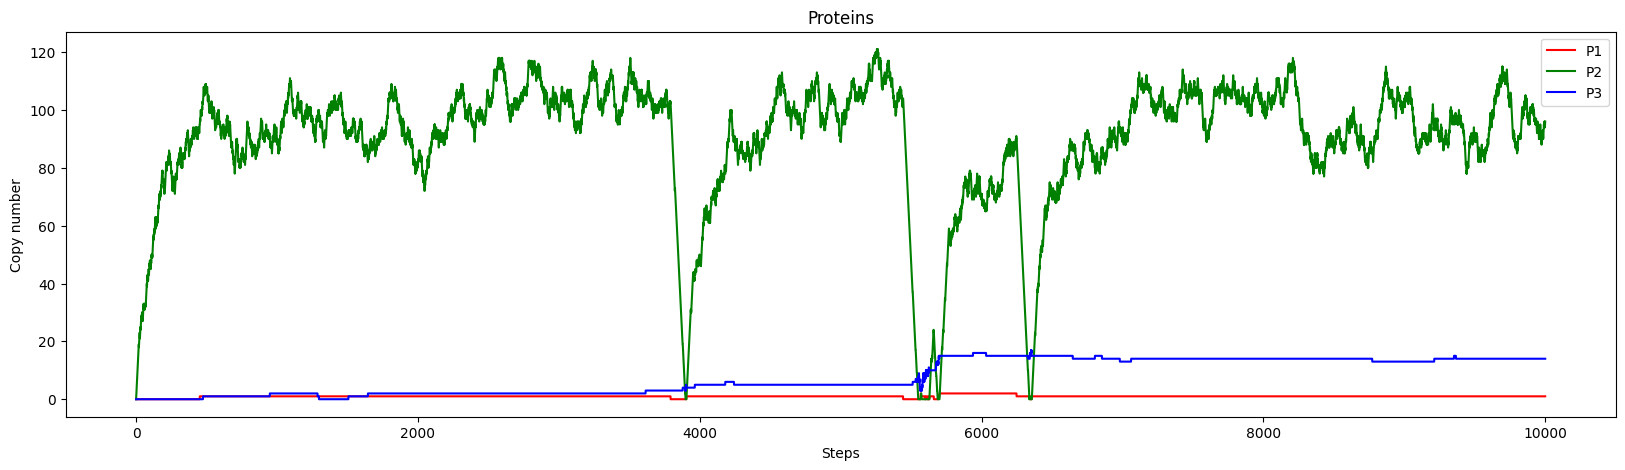

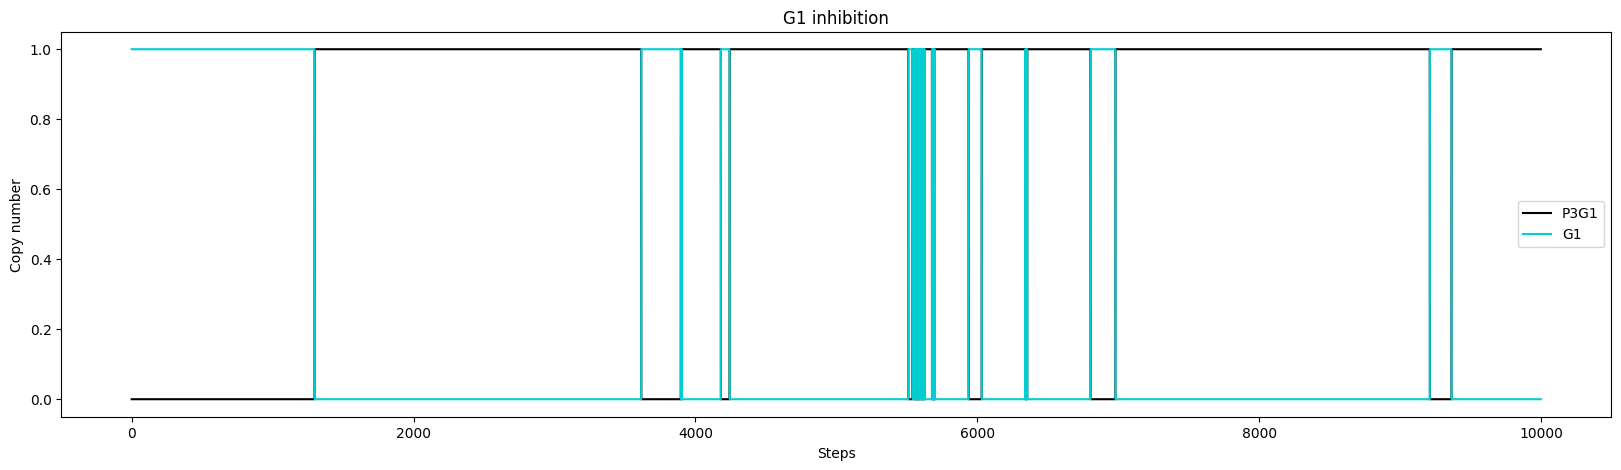

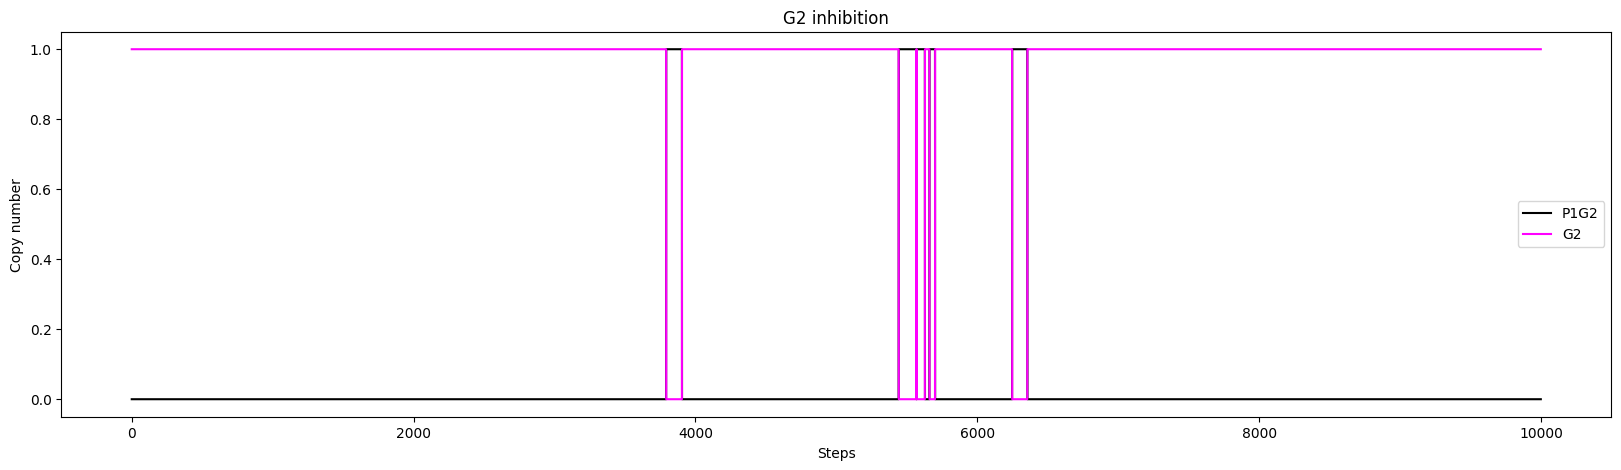

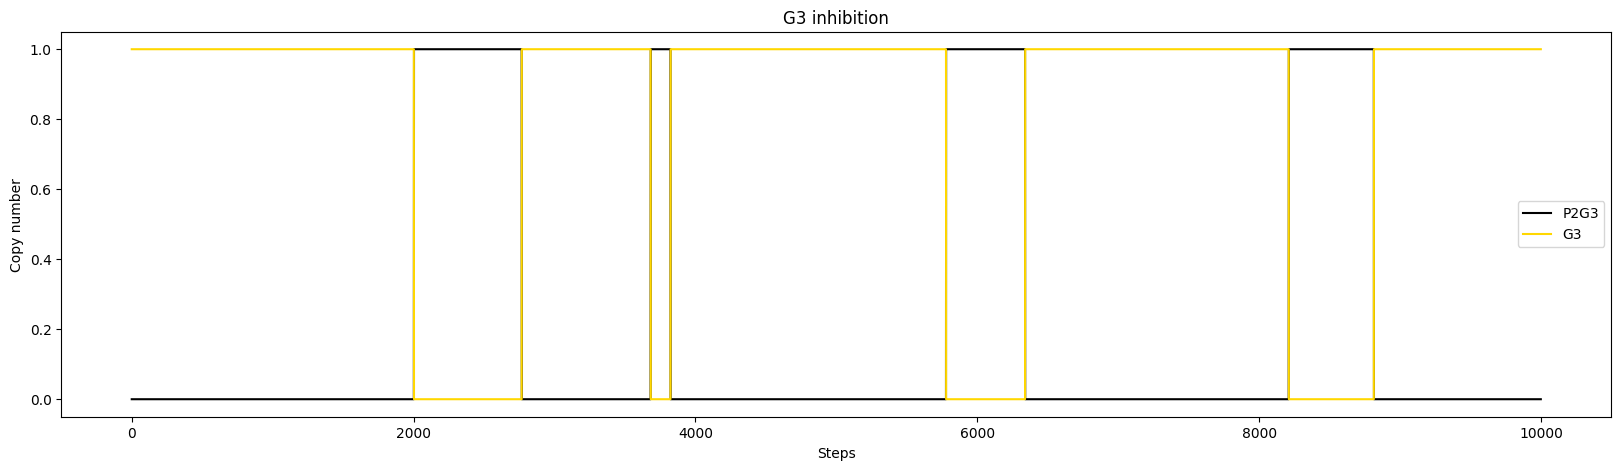

In [5]:
smod.DoStochSim(IsTrackPropensities=True, end=10000)
species_df = pd.DataFrame(smod.data_stochsim.species, columns=smod.data_stochsim.species_labels)
species_df[['P1', 'P2', 'P3']].plot(figsize=(20,5), color=['red', 'green', 'blue'], xlabel="Steps", ylabel="Copy number", title="Proteins")
species_df[['P3G1', 'G1']].plot(figsize=(20,5), color=['black', 'darkturquoise'], xlabel="Steps", ylabel="Copy number", title="G1 inhibition")
species_df[['P1G2', 'G2']].plot(figsize=(20,5), color=['black', 'magenta'], xlabel="Steps", ylabel="Copy number", title="G2 inhibition")
species_df[['P2G3', 'G3']].plot(figsize=(20,5), color=['black', 'gold'], xlabel="Steps", ylabel="Copy number", title="G3 inhibition")

Visualizing reaction propensities:

<Axes: title={'center': 'Protein degradation'}, xlabel='Steps', ylabel='Propensity'>

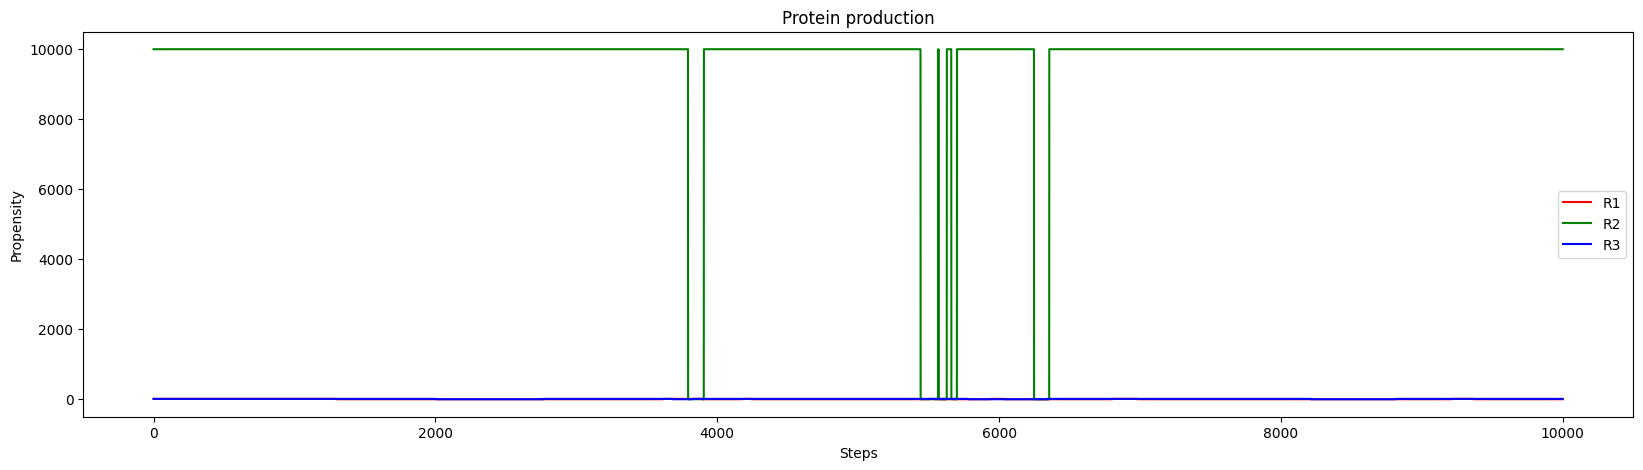

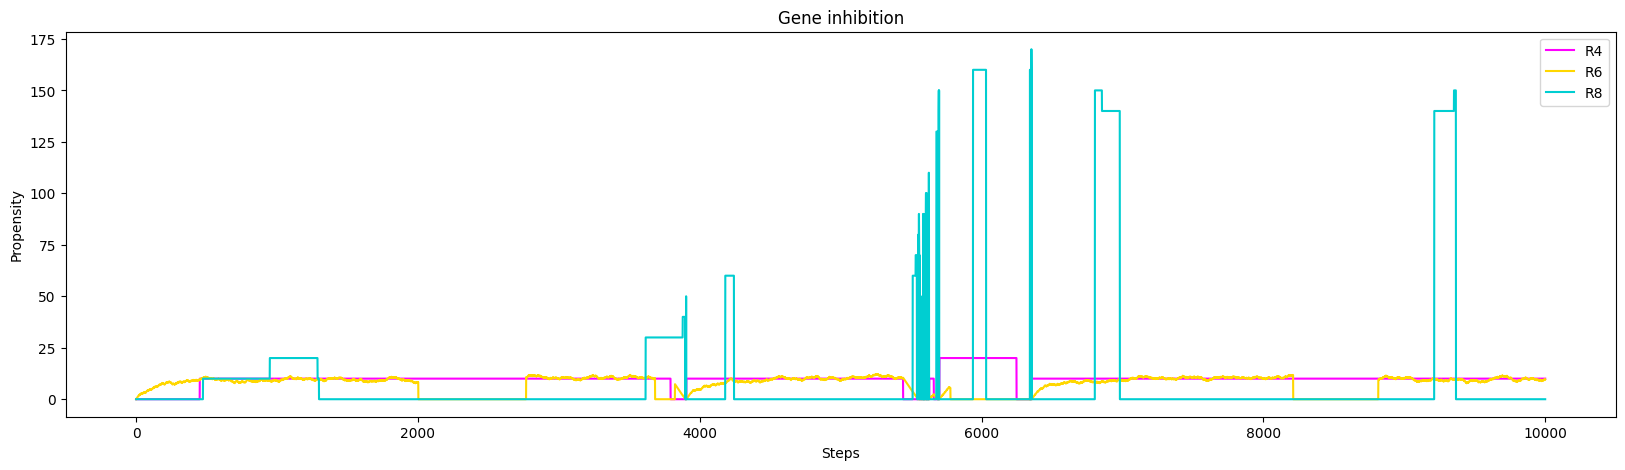

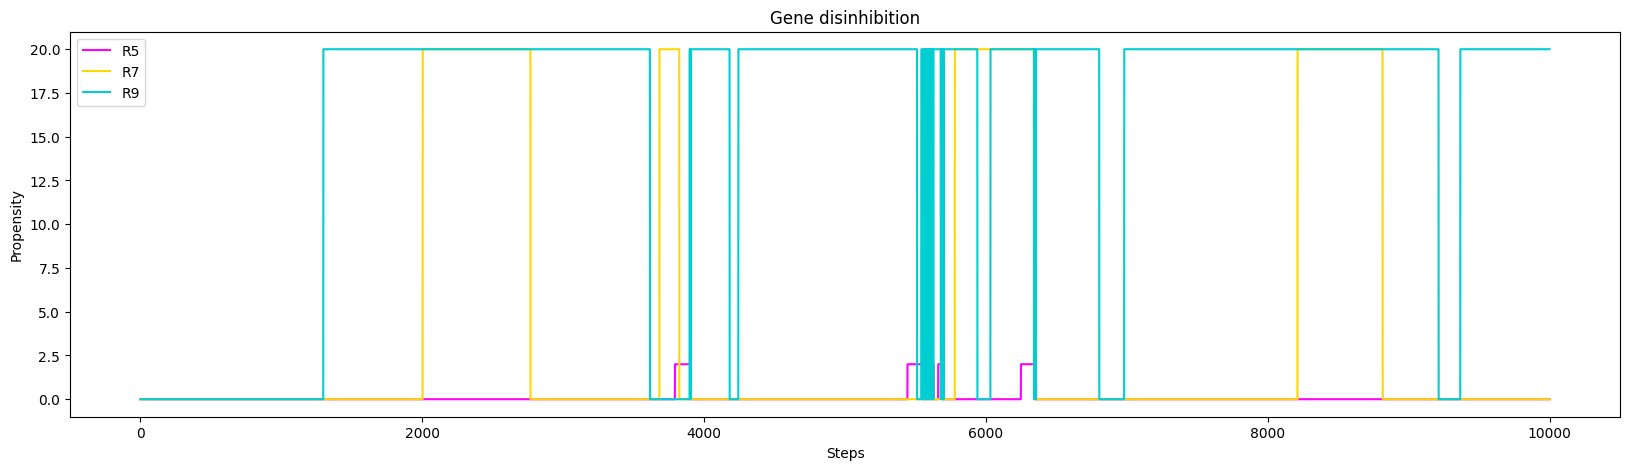

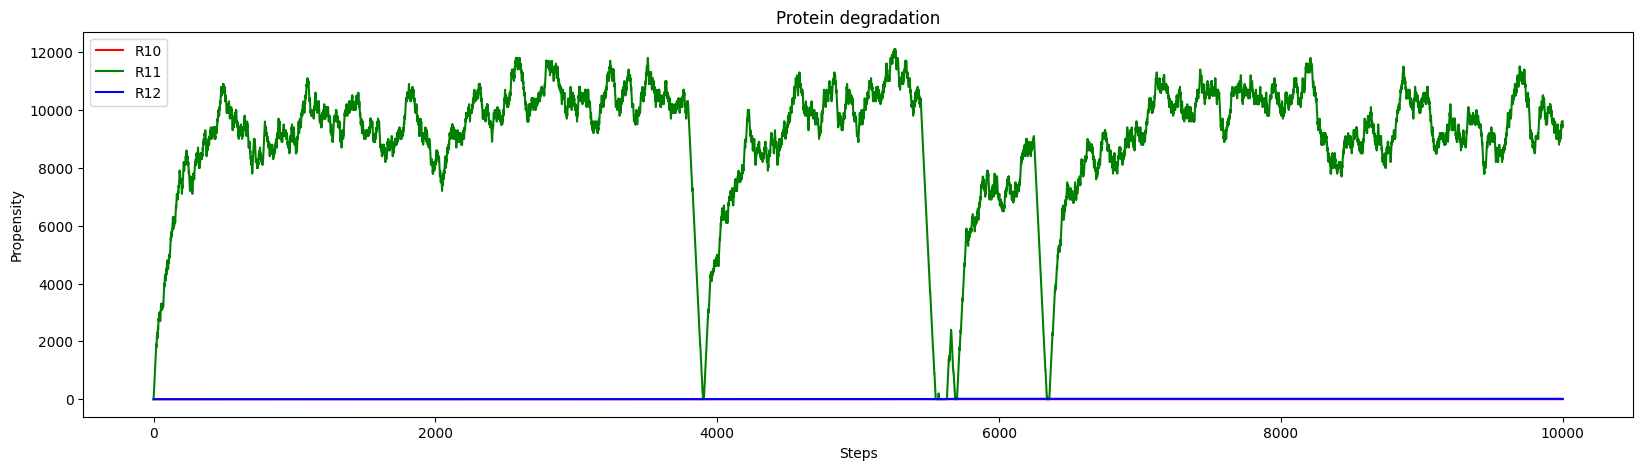

In [6]:
propensities_df = pd.DataFrame(smod.data_stochsim.propensities, columns=smod.data_stochsim.propensities_labels)
propensities_df[['R1', 'R2', 'R3']].plot(figsize=(20,5), color=['red', 'green', 'blue'], xlabel="Steps", ylabel="Propensity", title="Protein production")
propensities_df[['R4', 'R6', 'R8']].plot(figsize=(20,5), color=['magenta', 'gold', 'darkturquoise'], xlabel="Steps", ylabel="Propensity", title="Gene inhibition")
propensities_df[['R5', 'R7', 'R9']].plot(figsize=(20,5), color=['magenta', 'gold', 'darkturquoise'], xlabel="Steps", ylabel="Propensity", title="Gene disinhibition")
propensities_df[['R10', 'R11', 'R12']].plot(figsize=(20,5), color=['red', 'green', 'blue'], xlabel="Steps", ylabel="Propensity", title="Protein degradation")

Plotting the time between two subsequent firings of a reaction:

In [7]:
help(smod.PlotWaitingtimesDistributions)

Help on method PlotWaitingtimesDistributions in module stochpy.modules.StochPyPlot:

PlotWaitingtimesDistributions(rates2plot=True, linestyle='None', linewidth=1, marker='o', colors=None, title='', xlabel='inter-event time $t$', ylabel='PDF', IsLegend=True, legend_location='upper right') method of stochpy.modules.StochSim.SSA instance
    Plot event waiting time distributions            
    
    Input:
     - *rates2plot* [default = True]  as a list of strings ["R1","R2"]
     - *linestyle* [default = 'None'] dashed, dotted, dash_dot, and solid (string)
     - *linewidth* [default = 1] (float)
     - *marker* [default = 'o'] ('v','o','s',',','*','.')
     - *colors* [default =  None] (list)
     - *title* [default = ''] (string)
     - *xlabel* [default = 'inter-event time t'] (string)
     - *ylabel* [default = 'PDF'] (string)
     - *IsLegend* [default = True] (boolean)
     - *legend_location* [default = 'upper right'] (string/integer)



Reaction	Mean
R1	0.469
R2	5.142e-04
R3	0.071
R4	0.457
R5	0.497
R6	0.786
R7	0.784
R8	0.072
R9	0.071
R10	0.331
R11	5.239e-04
R12	0.121


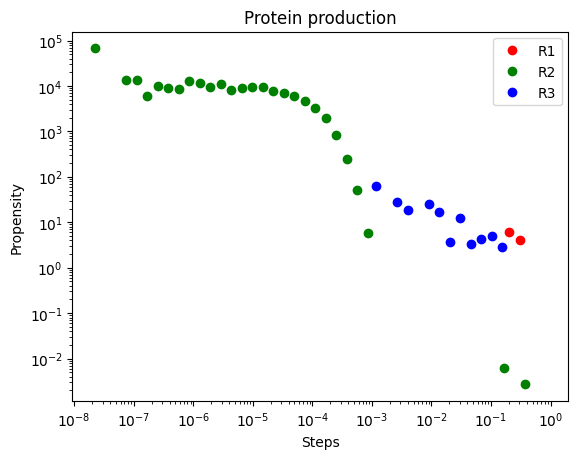

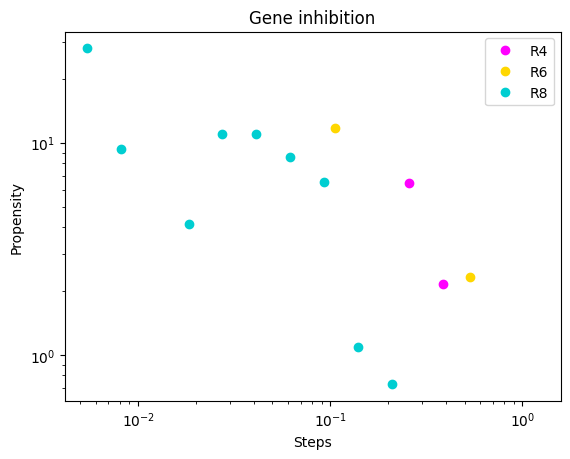

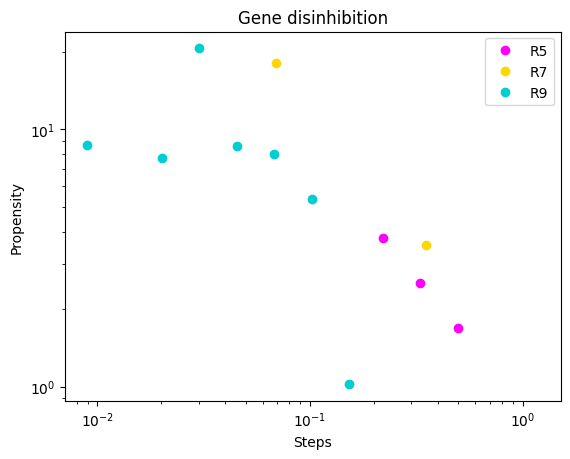

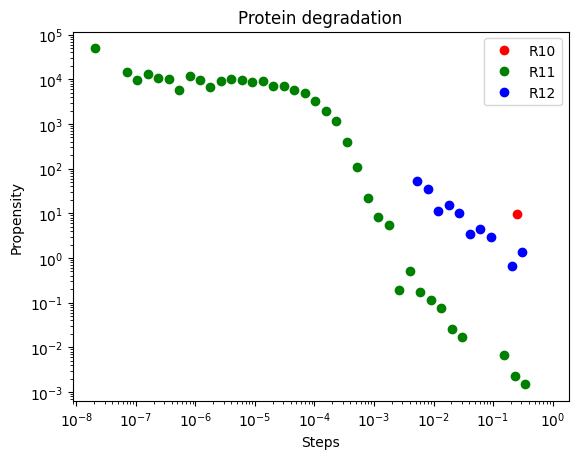

In [8]:
smod.PlotWaitingtimesDistributions(rates2plot=['R1', 'R2', 'R3'], colors=['red', 'green', 'blue'], xlabel="Steps", ylabel="Propensity", title="Protein production")
smod.PlotWaitingtimesDistributions(rates2plot=['R4', 'R6', 'R8'], colors=['magenta', 'gold', 'darkturquoise'], xlabel="Steps", ylabel="Propensity", title="Gene inhibition")
smod.PlotWaitingtimesDistributions(rates2plot=['R5', 'R7', 'R9'], colors=['magenta', 'gold', 'darkturquoise'], xlabel="Steps", ylabel="Propensity", title="Gene disinhibition")
smod.PlotWaitingtimesDistributions(rates2plot=['R10', 'R11', 'R12'], colors=['red', 'green', 'blue'], xlabel="Steps", ylabel="Propensity", title="Protein degradation")
smod.PrintWaitingtimesMeans()

To approximate the deterministic behavior we can either perform multiple stochastic simulations and average the species copy numbers at each time point:

Info: 100 trajectories are generated
Info: Time simulation output of the trajectories is stored at negative_feedback_loop(trajectory).dat in directory: /Users/irenetesta/Stochpy/temp
Info: Simulation time: 0.16893577575683594                                                   

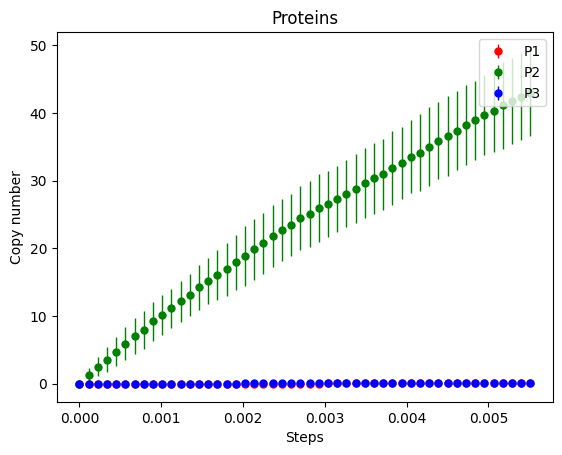

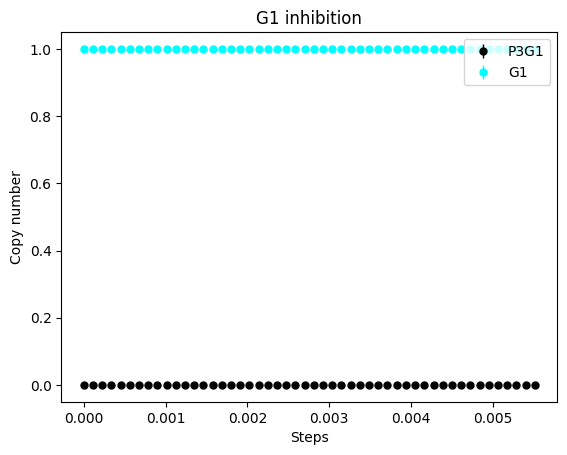

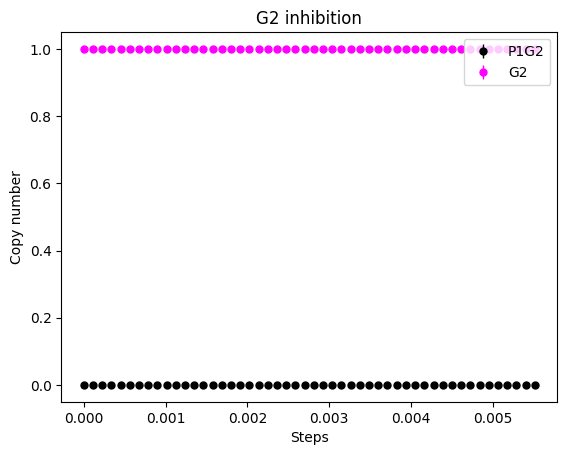

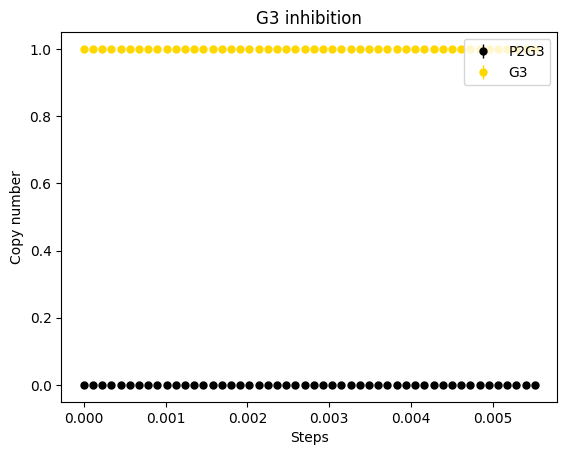

In [9]:
smod.DoStochSim(end=100, trajectories=100)
smod.GetRegularGrid(n_samples=50)
smod.PlotAverageSpeciesTimeSeries(species2plot=['P1', 'P2', 'P3'], colors=['red', 'green', 'blue'], xlabel="Steps", ylabel="Copy number", title="Proteins")
smod.PlotAverageSpeciesTimeSeries(species2plot=['P3G1', 'G1'], colors=['black', 'cyan'], xlabel="Steps", ylabel="Copy number", title="G1 inhibition")
smod.PlotAverageSpeciesTimeSeries(species2plot=['P1G2', 'G2'], colors=['black', 'magenta'], xlabel="Steps", ylabel="Copy number", title="G2 inhibition")
smod.PlotAverageSpeciesTimeSeries(species2plot=['P2G3', 'G3'], colors=['black', 'gold'], xlabel="Steps", ylabel="Copy number", title="G3 inhibition")

Computing mean and standard deviation of the species copy number is not straightforward as the time between two events is not constant, thus it is necessary to track the time spent in each state for each species. This computation is implemented by the following functions:

In [10]:
smod.PrintSpeciesMeans()
smod.PrintSpeciesStandardDeviations()

Species	Mean
G1	1.000
P1	0.000e+00
G2	1.000
P2	32.852
G3	1.000
P3	0.000e+00
P1G2	0.000e+00
P2G3	0.000e+00
P3G1	0.000e+00
Species	Standard Deviation
G1	0.000e+00
P1	0.000e+00
G2	0.000e+00
P2	15.813
G3	0.000e+00
P3	0.000e+00
P1G2	0.000e+00
P2G3	0.000e+00
P3G1	0.000e+00


To get an accurate prediction of the species distribution StochPy provides the function `DoCompleteStochSim()` that continues the simulation until the first four moments converge within a user-specified error:

In [11]:
# smod.DoCompleteStochSim()
# smod.PlotSpeciesDistributions()

## ODE model

\begin{cases}
\frac{\partial G_1}{\partial t}=-r_{B_3} \cdot P_3\cdot G_1 + r_{U_3} \cdot P_3G_1\\
\frac{\partial G_2}{\partial t}=-r_{B_1} \cdot P_1\cdot G_2 + r_{U_1} \cdot P_1G_2\\
\frac{\partial G_3}{\partial t}=-r_{B_2} \cdot P_2\cdot G_3 + r_{U_2} \cdot P_2G_3\\\
\frac{\partial P_1}{\partial t}=r_{P_1}\cdot G_1 - r_{B_1} \cdot P_1\cdot G_2 + r_{U_1}\cdot P_1G_2 - r_{D_1}\cdot P_1\\
\frac{\partial P_2}{\partial t}=r_{P_2}\cdot G_2- r_{B_2}\cdot P_2\cdot G_3+r_{U_2}\cdot P_2G_3-r_{D_2}\cdot P_2\\
\frac{\partial P_3}{\partial t}=r_{P_3}\cdot G_3- r_{B_3}\cdot P_3\cdot G_1 +r_{U_3} \cdot P_3G_1-r_{D_3}\cdot P_3\\
\frac{\partial P_1G_2}{\partial t}=r_{B_1}\cdot P_1\cdot G_2 - r_{U_1} \cdot P_1G_2\\
\frac{\partial P_2G_3}{\partial t}=r_{B_2}\cdot P_2\cdot G_3 - r_{U_2}\cdot P_2G_3\\
\frac{\partial P_3G_1}{\partial t}=r_{B_3}\cdot P_3\cdot G_1 - r_{U_3} \cdot P_3G_1\\
\end{cases}

The `odeint` method from `scipy.integrate` solves a system of ordinary differential equations using lsoda from the FORTRAN library odepack. This library uses the Adams/BDF method with automatic stiffness detection and switching.

In [12]:
def ODE_solver(t, rates, init):
    '''
    Solve the initial value problem for the ODE system.
    '''
    def neg_feedback_loop(x0, t, rates):
        G1, G2, G3, P1, P2, P3, P1G2, P2G3, P3G1 = x0
        d_G1_dt = -rates['rB3']*P3*G1 + rates['rU3']*P3G1
        d_G2_dt = -rates['rB1']*P1*G2 + rates['rU1']*P1G2
        d_G3_dt = -rates['rB2']*P2*G3 + rates['rU2']*P2G3
        d_P1_dt = +rates['rP1']*G1 - rates['rB1']*P1*G2 + rates['rU1']*P1G2 - rates['rD1']*P1
        d_P2_dt = +rates['rP2']*G2 - rates['rB2']*P2*G3 + rates['rU2']*P2G3 - rates['rD2']*P2
        d_P3_dt = +rates['rP3']*G3 - rates['rB3']*P3*G1 + rates['rU3']*P3G1 - rates['rD3']*P3
        d_P1G2_dt = +rates['rB1']*P1*G2 - rates['rU1']*P1G2
        d_P2G3_dt = +rates['rB2']*P2*G3 - rates['rU2']*P2G3
        d_P3G1_dt = +rates['rB3']*P3*G1 - rates['rU3']*P3G1
        return [d_G1_dt, d_G2_dt, d_G3_dt, d_P1_dt, d_P2_dt, d_P3_dt, d_P1G2_dt, d_P2G3_dt, d_P3G1_dt]

    x0 = [init['G1'], init['G2'], init['G3'], init['P1'], init['P2'], init['P3'], init['P1G2'], init['P2G3'], init['P3G1']]
    y = odeint(neg_feedback_loop, x0, t, args=(rates,))
    results_df = pd.DataFrame(y, columns=['$G_1$', '$G_2$', '$G_3$', '$P_1$', '$P_2$', '$P_3$', '$P_1G_2$', '$P_2G_3$', '$P_3G_1$'])
    return results_df

Simulate the system for 50 time units with the following initial conditions:

<Axes: >

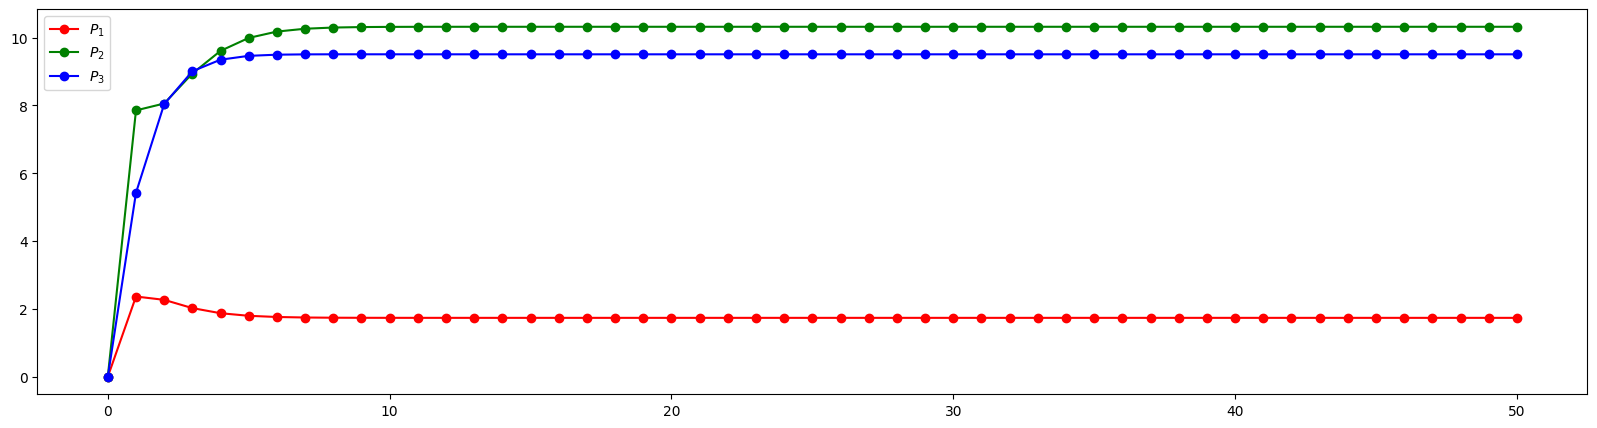

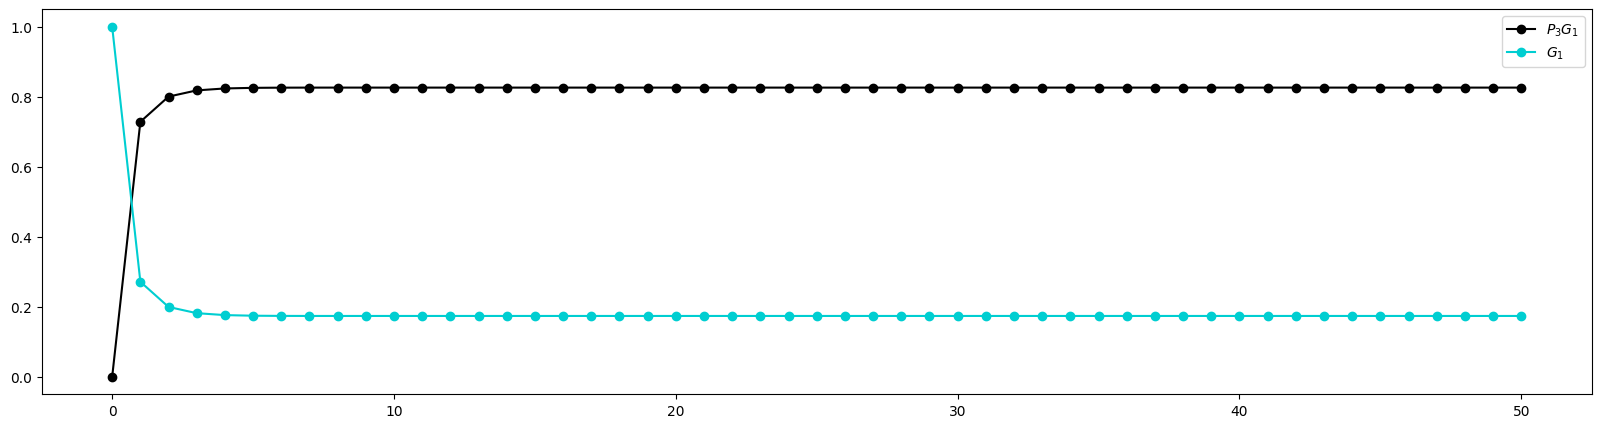

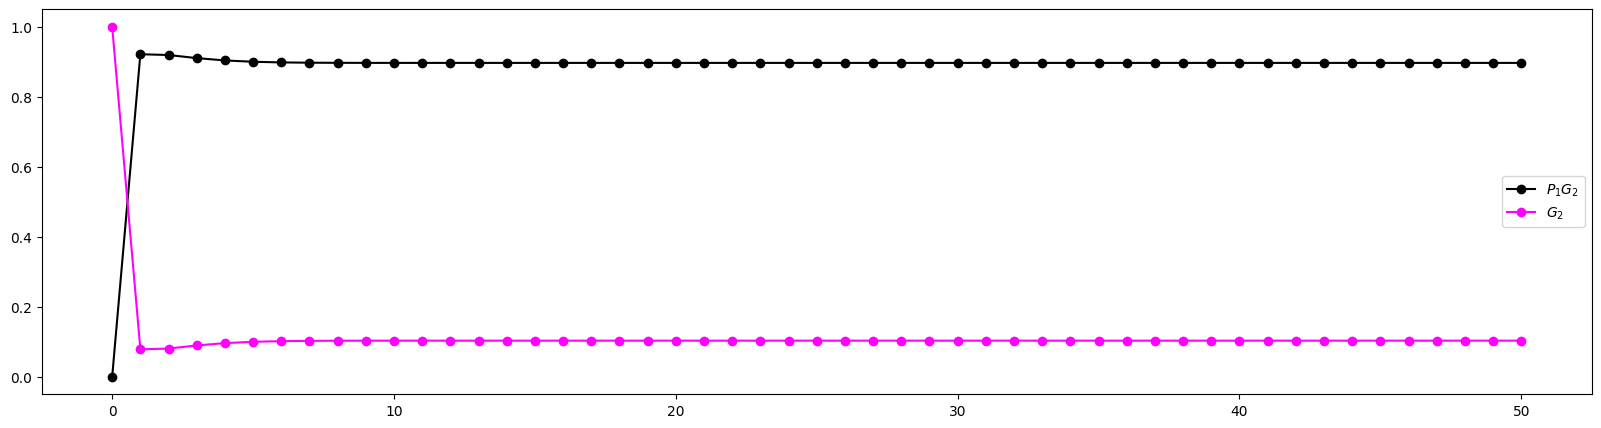

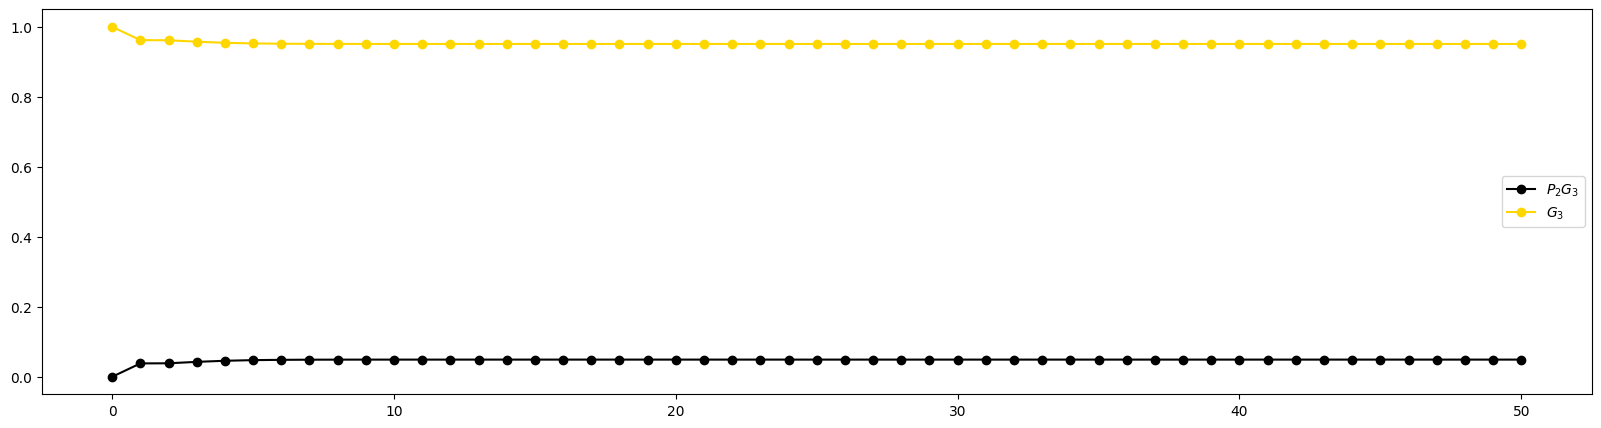

In [13]:
t = np.linspace(0,50,51)
rates = {
    'rP1': 10,
    'rP2': 10000,
    'rP3': 10,
    'rB1': 10,
    'rB2': 0.1,
    'rB3': 10,
    'rU1': 2,
    'rU2': 20,
    'rU3': 20,
    'rD1': 1,
    'rD2': 100,
    'rD3': 1
}
init = {
    'G1': 1,
    'G2': 1,
    'G3': 1,
    'P1': 0,
    'P2': 0,
    'P3': 0,
    'P1G2': 0,
    'P2G3': 0,
    'P3G1': 0
}
results_df = ODE_solver(t, rates, init)
results_df[['$P_1$', '$P_2$', '$P_3$']].plot(figsize=(20,5), color=['red', 'green', 'blue'], marker="o")
results_df[['$P_3G_1$', '$G_1$']].plot(figsize=(20,5), color=['black', 'darkturquoise'], marker="o")
results_df[['$P_1G_2$', '$G_2$']].plot(figsize=(20,5), color=['black', 'magenta'], marker="o")
results_df[['$P_2G_3$', '$G_3$']].plot(figsize=(20,5), color=['black', 'gold'], marker="o")

In [14]:
from scipy.integrate import ode

def ODE_solver2(t, rates, init, method='dop853'):
    '''
    Solve the initial value problem for the ODE system using scipy.integrate.ode.
    '''
    def neg_feedback_loop(t, x, rates):
        G1, G2, G3, P1, P2, P3, P1G2, P2G3, P3G1 = x
        d_G1_dt = -rates['rB3']*P3*G1 + rates['rU3']*P3G1
        d_G2_dt = -rates['rB1']*P1*G2 + rates['rU1']*P1G2
        d_G3_dt = -rates['rB2']*P2*G3 + rates['rU2']*P2G3
        d_P1_dt = +rates['rP1']*G1 - rates['rB1']*P1*G2 + rates['rU1']*P1G2 - rates['rD1']*P1
        d_P2_dt = +rates['rP2']*G2 - rates['rB2']*P2*G3 + rates['rU2']*P2G3 - rates['rD2']*P2
        d_P3_dt = +rates['rP3']*G3 - rates['rB3']*P3*G1 + rates['rU3']*P3G1 - rates['rD3']*P3
        d_P1G2_dt = +rates['rB1']*P1*G2 - rates['rU1']*P1G2
        d_P2G3_dt = +rates['rB2']*P2*G3 - rates['rU2']*P2G3
        d_P3G1_dt = +rates['rB3']*P3*G1 - rates['rU3']*P3G1
        return [d_G1_dt, d_G2_dt, d_G3_dt, d_P1_dt, d_P2_dt, d_P3_dt, d_P1G2_dt, d_P2G3_dt, d_P3G1_dt]

    # Convert the time vector to a list of times for interpolation
    t_values = np.array(t)
    y_values = np.zeros((len(t_values), 9))
    
    # Initial conditions
    x0 = [init['G1'], init['G2'], init['G3'], init['P1'], init['P2'], init['P3'], init['P1G2'], init['P2G3'], init['P3G1']]
    
    # Create an ODE integrator object
    solver = ode(lambda t, x: neg_feedback_loop(t, x, rates))
    solver.set_integrator(method)  # You can choose different integrators available in scipy
    solver.set_initial_value(x0, t[0])
    
    # Integrate the ODE system
    for i in range(len(t_values)):
        if solver.successful() and solver.t < t_values[i]:
            solver.integrate(t_values[i])
        y_values[i, :] = solver.y
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(y_values, columns=['$G_1$', '$G_2$', '$G_3$', '$P_1$', '$P_2$', '$P_3$', '$P_1G_2$', '$P_2G_3$', '$P_3G_1$'])
    return results_df


/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_6167/3099431408.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  y_values[i, :] = solver.y


<Axes: >

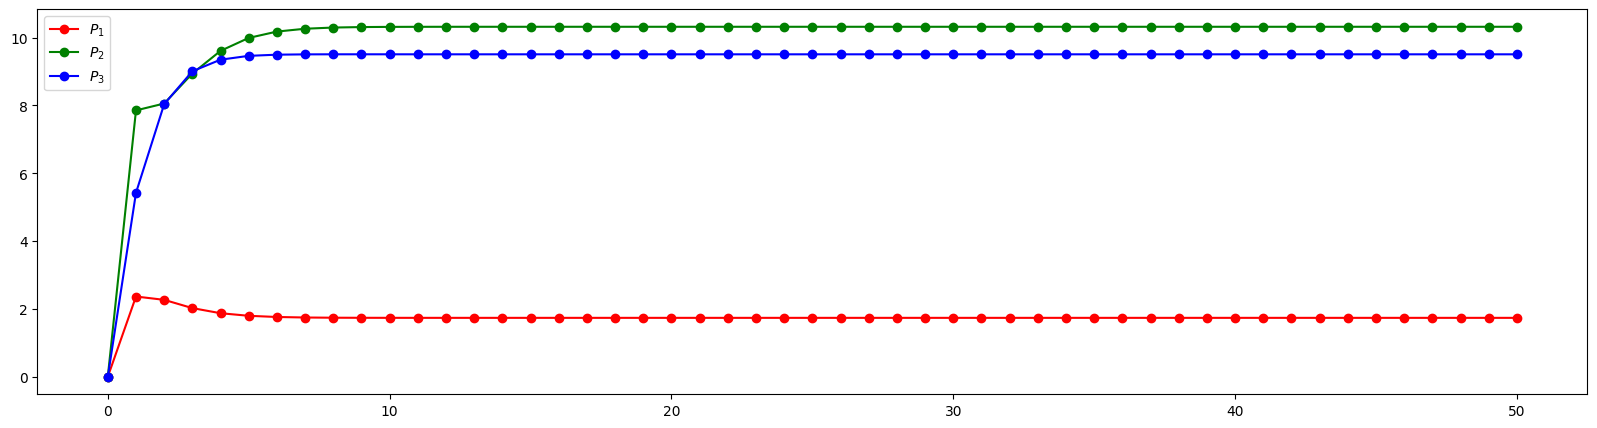

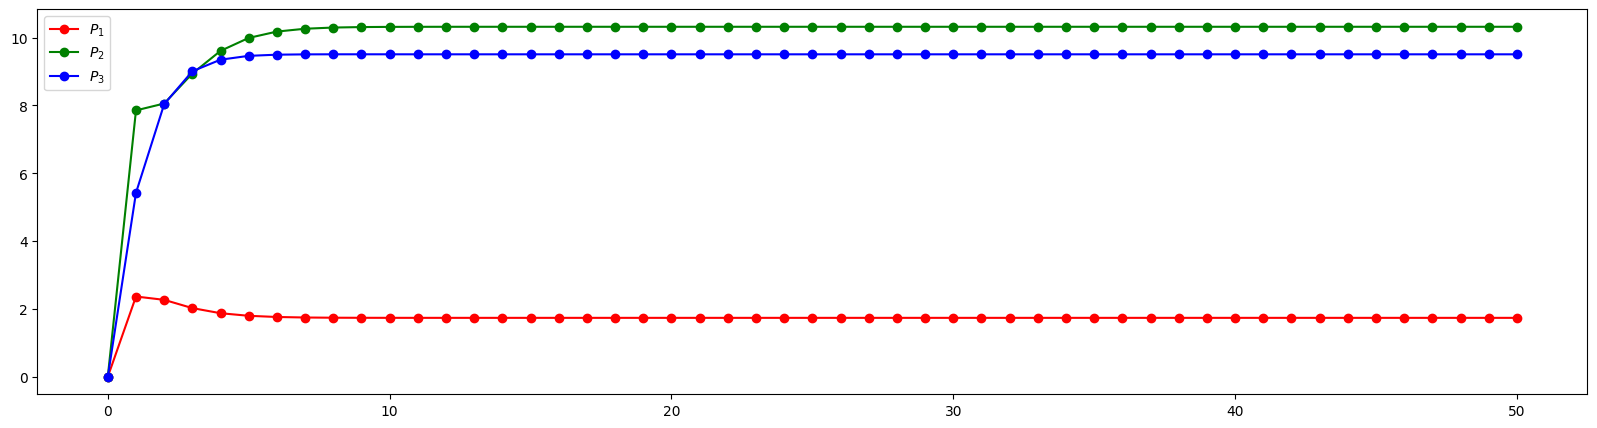

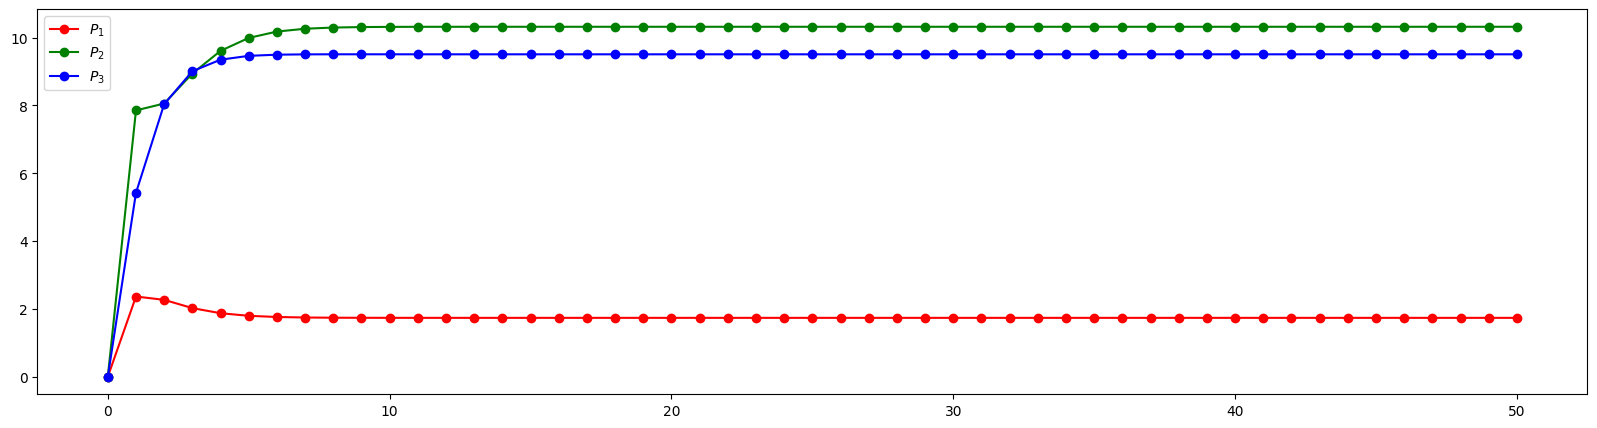

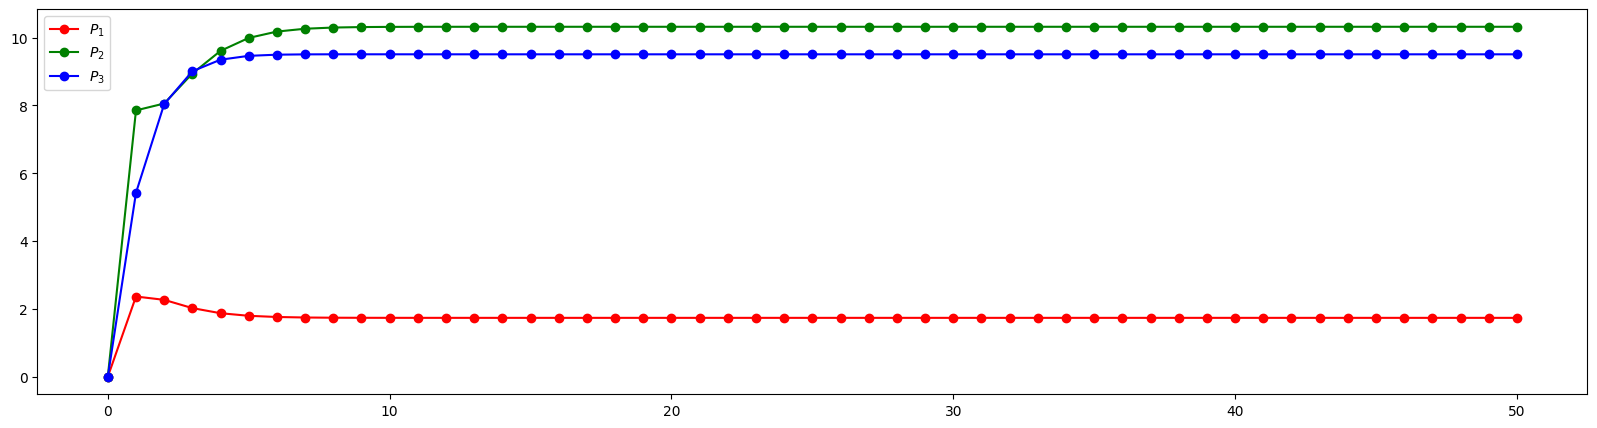

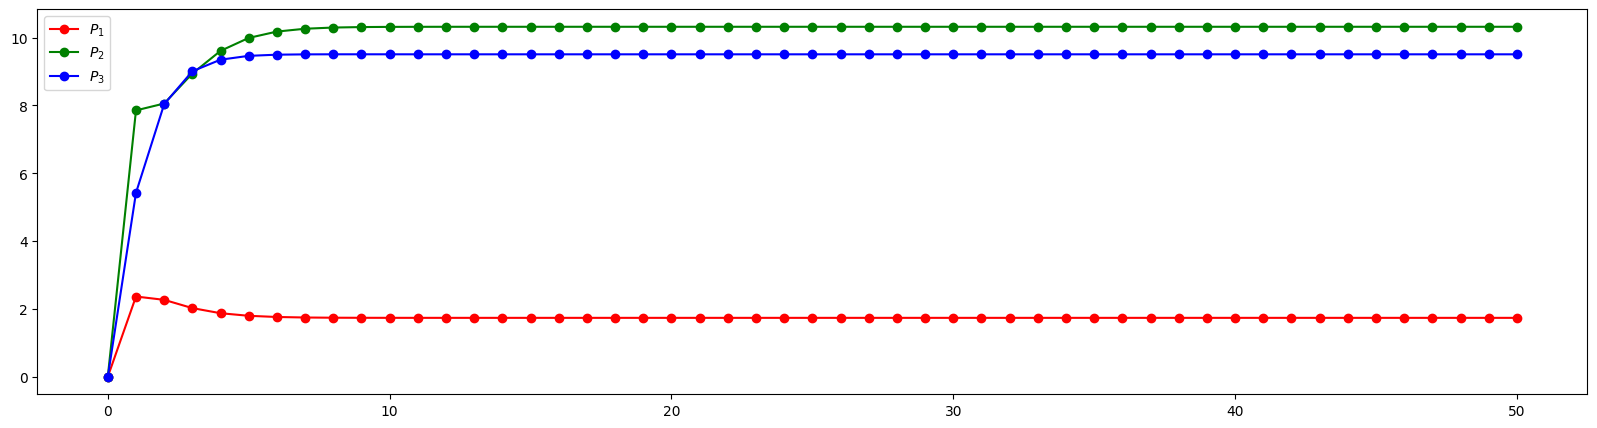

In [15]:
results1_df = ODE_solver2(t, rates, init, 'vode')
results1_df[['$P_1$', '$P_2$', '$P_3$']].plot(figsize=(20,5), color=['red', 'green', 'blue'], marker="o")

results2_df = ODE_solver2(t, rates, init, 'zvode')
results2_df[['$P_1$', '$P_2$', '$P_3$']].plot(figsize=(20,5), color=['red', 'green', 'blue'], marker="o")

results3_df = ODE_solver2(t, rates, init, 'lsoda')
results3_df[['$P_1$', '$P_2$', '$P_3$']].plot(figsize=(20,5), color=['red', 'green', 'blue'], marker="o")

results4_df = ODE_solver2(t, rates, init, 'dopri5')
results4_df[['$P_1$', '$P_2$', '$P_3$']].plot(figsize=(20,5), color=['red', 'green', 'blue'], marker="o")

results5_df = ODE_solver2(t, rates, init, 'dop853')
results5_df[['$P_1$', '$P_2$', '$P_3$']].plot(figsize=(20,5), color=['red', 'green', 'blue'], marker="o")